In [88]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1.json")


# data = load_data("../stats/fpm_0_sticking_solver_1.json")
# data = load_data("../stats/fpm_1_sliding_solver_1.json")
data = load_data("../stats/fpm_1_sticking_solver_1.json")
# data = load_data("../stats/fpm_1_open_solver_1.json")
# data = load_data("../stats/fpm_1_m_sliding_solver_1.json")

In [89]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

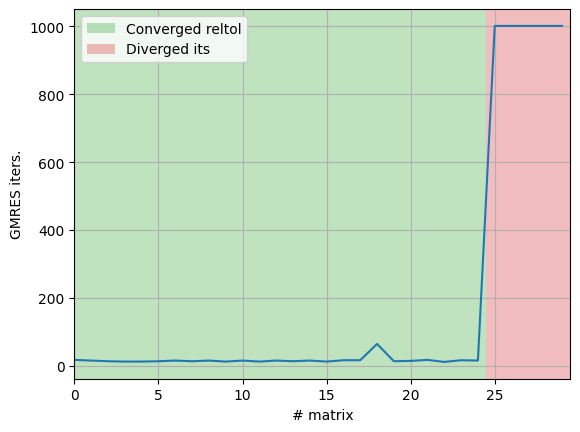

In [90]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [91]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

16

In [92]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
print(sticking[mat_idx], sliding[mat_idx], open_[mat_idx])

27 45 0


In [93]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.16


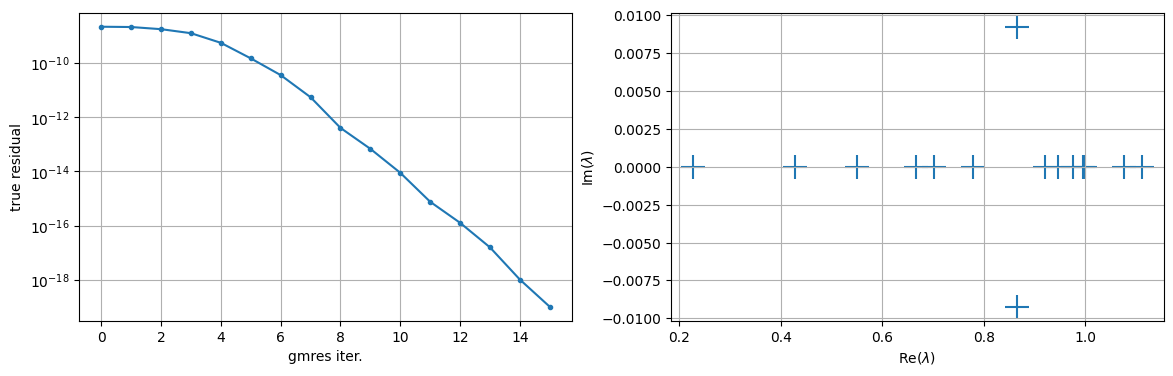

In [94]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

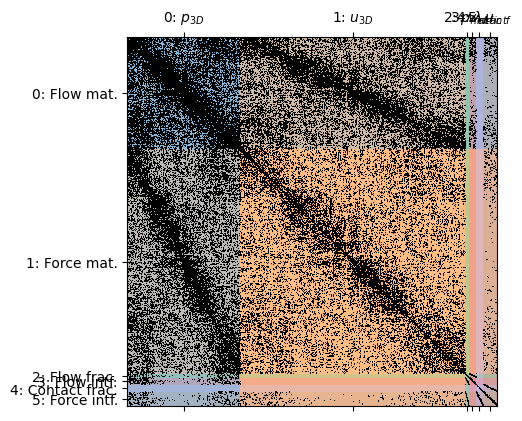

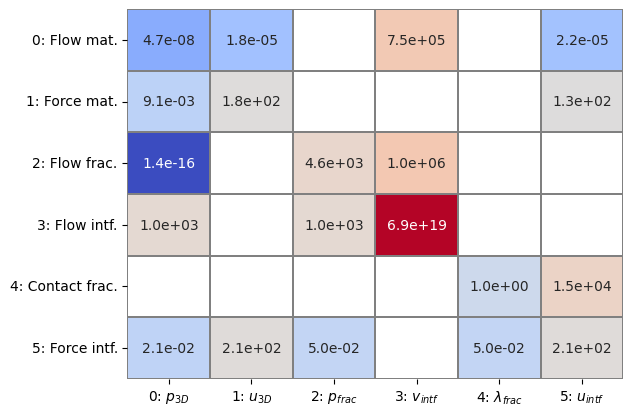

In [95]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

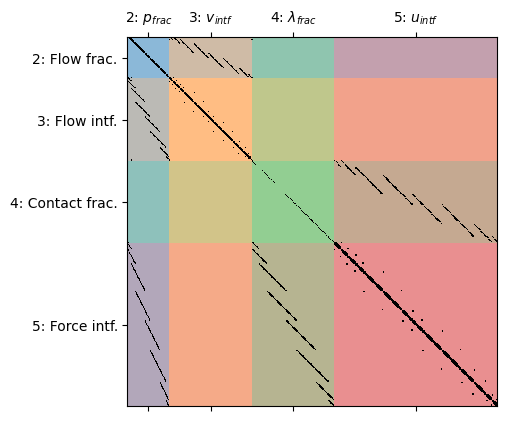

In [96]:
J[2:, 2:].color_spy()

Solve  took: 0.09


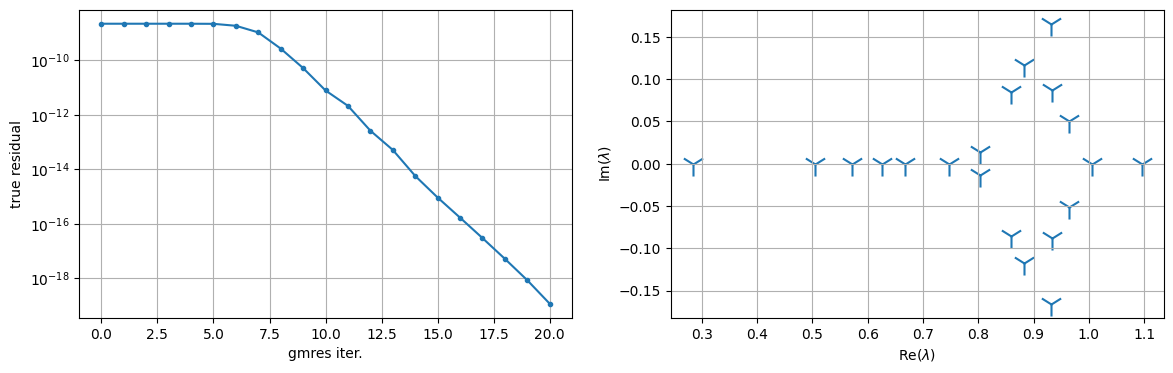

In [97]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv

schema15_amg = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv(model=model, bmat=J, lump=True),
    complement=schema15_amg,
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

Solve  took: 0.17


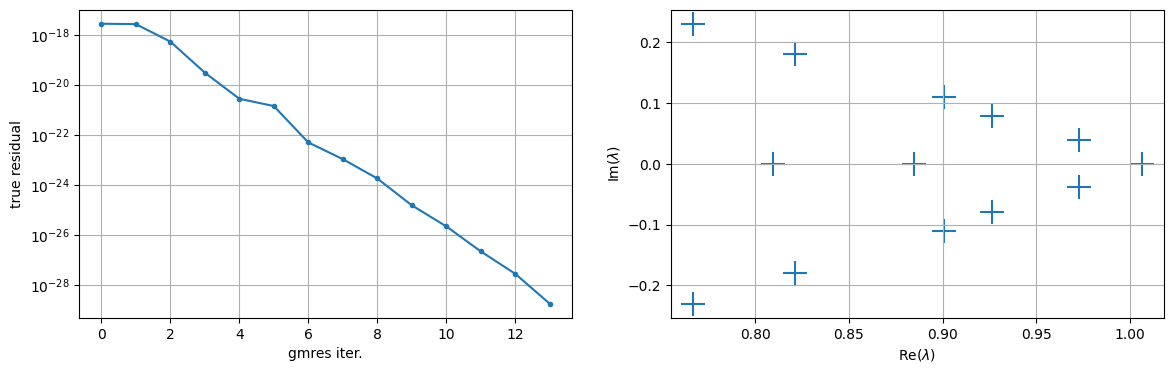

In [52]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization_nd, get_fixed_stress_stabilization
from preconditioner_mech import make_J44_inv
from scipy.sparse import csr_matrix


def custom_inv(J15: BlockMatrixStorage):
    # return bmat(
    #     [
    #         [csr_matrix(J15[1, 1].shape), csr_matrix(J15[1, 5].shape)],
    #         [csr_matrix(J15[5, 1].shape), inv(J15[5, 5].mat)],
    #     ]
    # )
    J15.mat = inv(J15.mat)
    J15[1, 1] = 0
    J15[1, 5] = 0
    J15[5, 1] = 0
    return J15.mat


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    # solve=lambda bmat: inv(bmat.mat),
    # invertor=lambda bmat: inv_block_diag(diag_nd(bmat.mat, nd=model.nd), nd=model.nd),
    # invertor=lambda bmat: scipy.sparse.csr_matrix(bmat.shape),
    invertor=custom_inv,
    complement=SolveSchema(
        groups=[4],
        # solve=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
        solve=lambda bmat: inv(bmat.mat),

        # complement=SolveSchema(
        #     groups=[1],
        #     solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
        # ),
    ),
)


mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.0
PETSc Converged Reason: -5


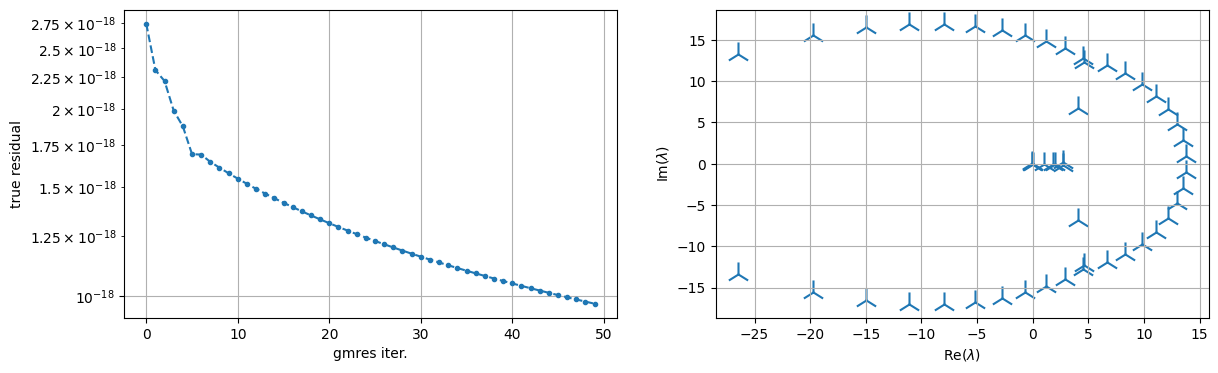

In [28]:
def pinv_left(mat):
    # A+ * A = I
    # Good for J54
    # Lin. indep. columns
    return inv(mat.T * mat) * mat.T


def pinv_right(mat):
    # A * A+ = I
    # Good for J45
    # Lin. indep. rows
    return mat.T * inv(mat * mat.T)


from scipy.sparse import csr_matrix

# def inv_or_0(block_matrices):
#     result = []
#     for bmat in block_matrices


def make_inv(
    J44: BlockMatrixStorage,
    J45: BlockMatrixStorage,
    J54: BlockMatrixStorage,
    J55: BlockMatrixStorage,
):
    return bmat(
        [
            [csr_matrix(J44.shape), pinv_left(J54.mat)],
            [csr_matrix(J54.shape), inv(J55.mat)]
        ]
    ).tocsr()

tmp = make_inv(J[4, 4], J[4,5], J[5,4], J[5,5])

solve_petsc(J[[4,5]].mat, tmp, J[[4,5]].local_rhs(rhs))

Solve  took: 0.4


Text(0.5, 1.0, 'Eigenvalues estimate')

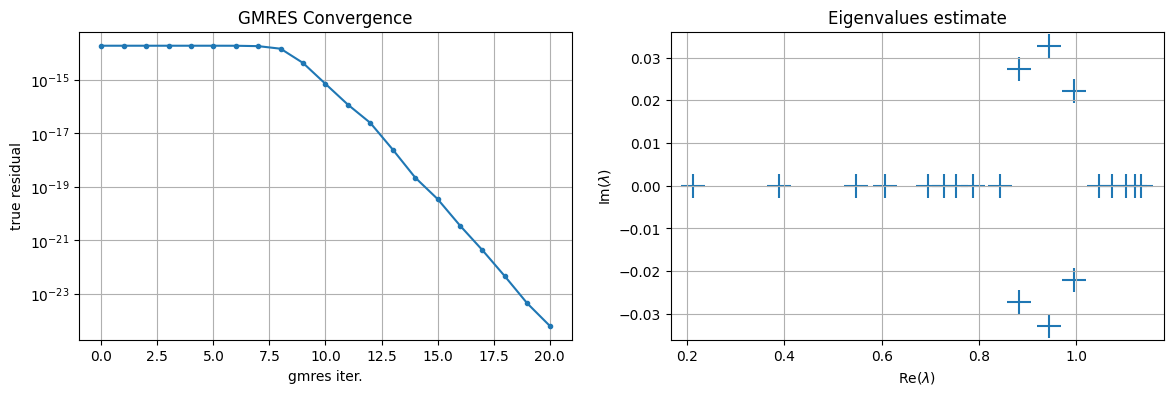

In [67]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[3],
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # solve=lambda bmat: PetscILU(bmat.mat),
    # solve=lambda bmat: make_J44_inv(model=model, bmat=J, lump=True),
    complement=SolveSchema(
        groups=[4, 5],
        complement=SolveSchema(
            groups=[1],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda: get_fixed_stress_stabilization(model),
            complement=SolveSchema(
                groups=[0, ],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        ),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
plt.subplot(1, 2, 1).set_title('GMRES Convergence')
plt.subplot(1, 2, 2).set_title('Eigenvalues estimate')

# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

Solve  took: 0.76
PETSc Converged Reason: -5


Text(0.5, 1.0, 'Eigenvalues estimate')

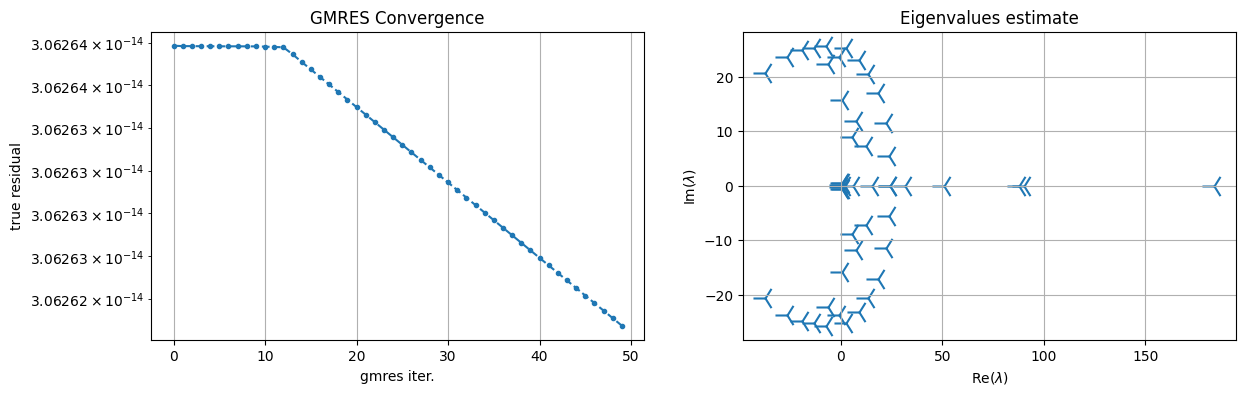

In [64]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[3],
    solve=lambda bmat: extract_diag_inv(bmat.mat),
    # solve=lambda bmat: PetscILU(bmat.mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: make_J44_inv(model=model, bmat=J, lump=True),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda: get_fixed_stress_stabilization_nd(model),
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        ),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
plt.subplot(1, 2, 1).set_title('GMRES Convergence')
plt.subplot(1, 2, 2).set_title('Eigenvalues estimate')

# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

Text(0.5, 1.0, 'GMRES Convergence')

Solve  took: 0.63
PETSc Converged Reason: -5


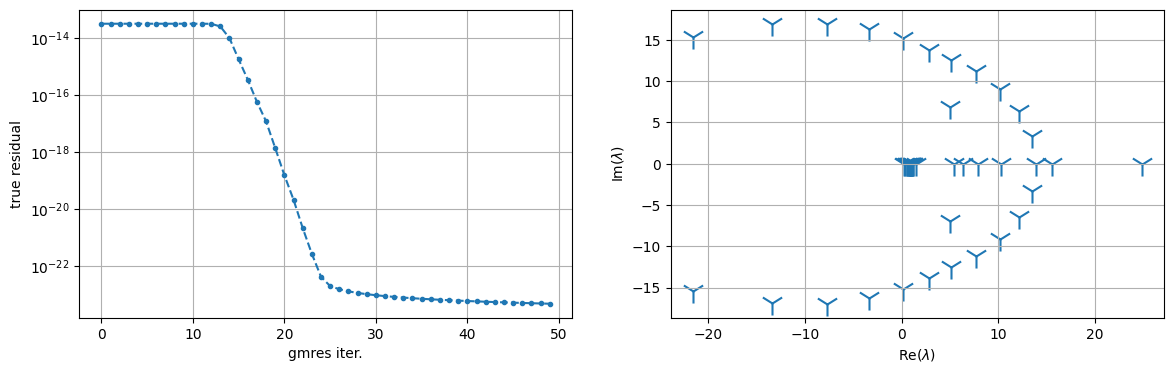

In [35]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[3],
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    complement=SolveSchema(
        groups=[4, 5],
        complement=SolveSchema(
            groups=[1],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda: get_fixed_stress_stabilization_nd(model),
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        ),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

Solve  took: 0.5
PETSc Converged Reason: -5


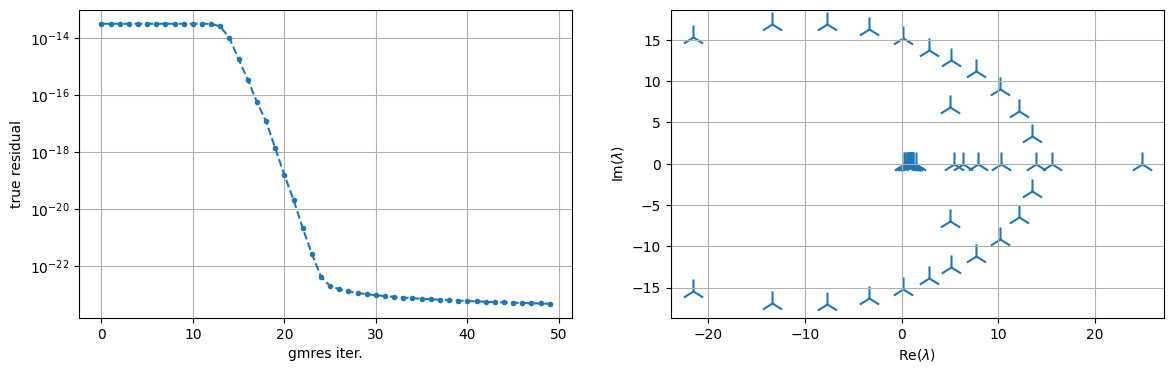

In [78]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[3],
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # solve=lambda bmat : make_J44_inv(model=model, bmat=J, lump=True),
    complement=SolveSchema(
        groups=[4, 5],
        complement=SolveSchema(
            groups=[1],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda: get_fixed_stress_stabilization_nd(model),
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        ),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

Solve  took: 0.05
PETSc Converged Reason: -5


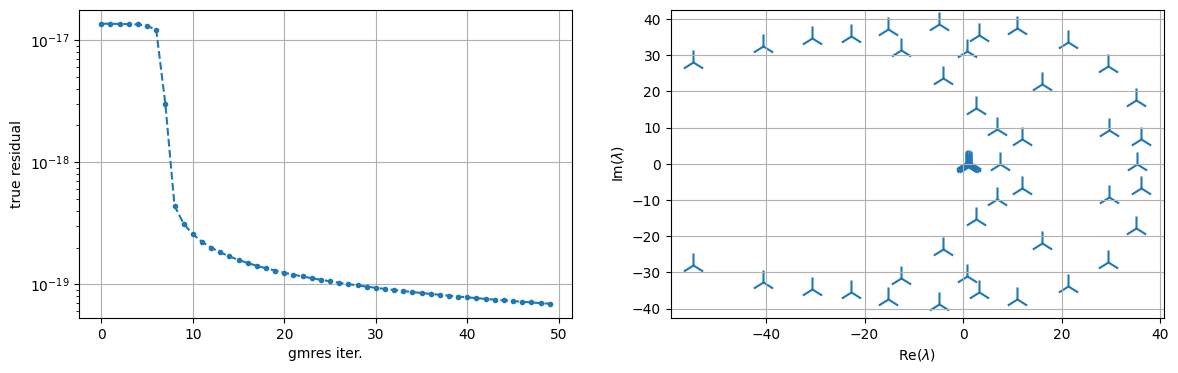

In [98]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[3],
    solve=lambda bmat: extract_diag_inv(bmat.mat),
    # solve=lambda bmat: make_J44_inv(model=model, bmat=J, lump=True),
    # complement=SolveSchema(
    #     groups=[4, 5],
        # complement=SolveSchema(
            # groups=[1],
            # solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            # invertor_type='physical',
            # invertor=lambda: get_fixed_stress_stabilization_nd(model),
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        # ),
    # ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

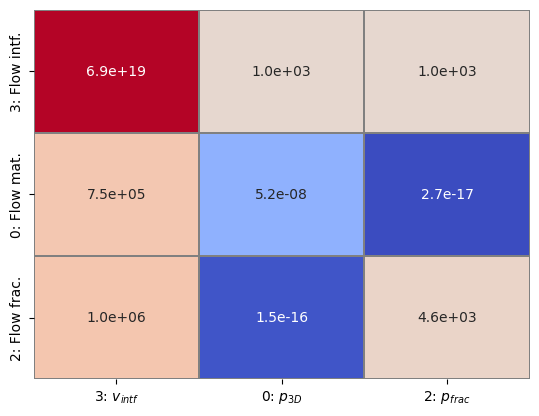

In [76]:
mat_permuted.plot_max()

Solve  took: 0.1


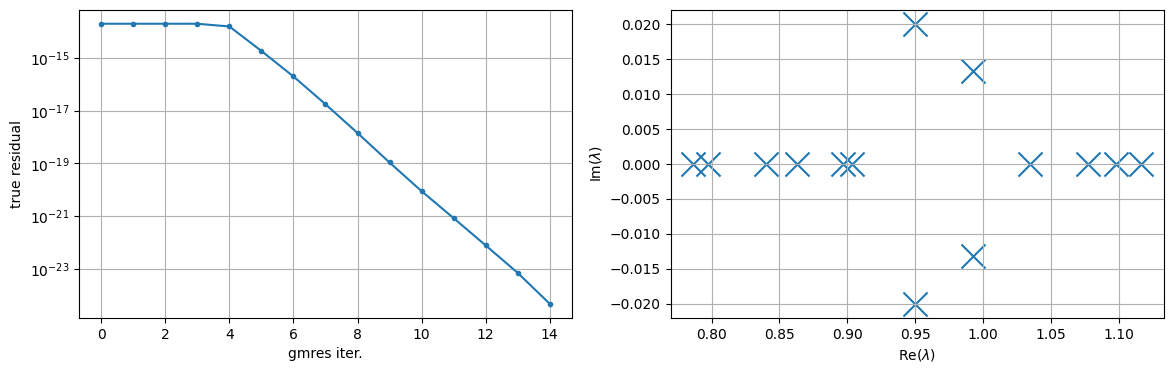

In [66]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    invertor=lambda: get_fixed_stress_stabilization(model),
    invertor_type='physical',
    complement=SolveSchema(
        groups=[0],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))